In [1]:
%reload_ext autoreload
%autoreload 2

import collections
import concurrent
import dataclasses
import enum
import functools
import io
import os
import pathlib
import re
import typing

import apex
import cv2
import fastai
import fastai.vision
import IPython
import numpy as np
import pandas as pd
import PIL
import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.tensorboard
import torchvision
import torch_lr_finder
from matplotlib import pyplot as plt

import pipeline

path = pathlib.Path('/mnt/data1/smc_data/challenge2')
path2 = pathlib.Path('/home/jin/sandbox/smc_challenge2/images')

In [2]:
img_path = path2/'img9'

cbed_data_loader = pipeline.CbedDataLoader(
    img_path, batch_size=1500, chans='L')

444018it [02:22, 3112.80it/s]
61200it [00:19, 3095.24it/s]


In [3]:
img_path12 = path2/'img12'

cbed_data_loader12 = pipeline.CbedDataLoader(
    img_path12, batch_size=1500, chans='L')

53025it [00:16, 3301.57it/s]
7320it [00:02, 3254.80it/s]


In [ ]:
save_filename = 'models/dropout_cutout0'
# save_filename = ''

with torch.utils.tensorboard.SummaryWriter(comment='__img9_0') as tbw:
    print(f"Logging to {tbw.log_dir}")
    tbw.add_text('desc', "dropout p=25%; cutout torch_default p=80%")
    if save_filename:
        tbw.add_text('save_filename', save_filename)

    learner = pipeline.Learner(
        model=pipeline.make_resnet34_1chan(
            pretrained=False,
            num_classes=len(cbed_data_loader.label_manager.raw_labels),
            dropout=0.25,
        ).cuda(),
        loss_fn=F.cross_entropy,
        tbw=tbw,
        train_loader=cbed_data_loader.train_loader,
        valid_loader=cbed_data_loader.valid_loader,
        topk=5,
    )
    learner.train_model(120, lr=3e-2, weight_decay=0.01)

pipeline.notify("training done")
if save_filename:
    pipeline.ModelOptBuf().save(learner.model, learner.opt, save_filename)

Logging to runs/Jun23_16-20-22_panda__img9_0


 12%|█▎        | 15/120 [38:11<4:27:31, 152.87s/it]

In [19]:
save_filename = '/tmp/dropout_cutout5'
# save_filename = ''

with torch.utils.tensorboard.SummaryWriter(comment='__img12_0') as tbw:
    tbw.add_text('desc', "dropout p=25%; cutout torch_default p=80%; label smoothing eps=0.05")
    if save_filename:
        tbw.add_text('save_filename', save_filename)
    num_classes = len(cbed_data_loader.label_manager.raw_labels)

    model = pipeline.make_resnet34_1chan(
        pretrained=False,
        num_classes=num_classes,
        dropout=0.25,
    ).cuda()

    lr = 3e-2
    opt = pipeline.Lamb2(
        model.parameters(), lr=lr, weight_decay=0.01)

    
    # loss_fn = F.cross_entropy
    loss_fn = pipeline.LabelSmoothingCrossEntropy(eps=0.05)
    
    learner = pipeline.Learner(
        model,
        loss_fn,
        opt,
        tbw,
        cbed_data_loader.train_loader,
        cbed_data_loader.valid_loader,
        topk=5,
    )
    learner.train_model(120, lr)
    
if save_filename:
    pipeline.ModelOptBuf().save(model, opt, save_filename)

100%|██████████| 120/120 [4:57:04<00:00, 148.54s/it] 


In [ ]:
outcomes_9 = pipeline.test_validation_set(img_path, model, cbed_data_loader.label_manager)

  5%|▍         | 979/20400 [01:53<36:56,  8.76it/s]

500


 10%|▉         | 1974/20400 [03:47<34:44,  8.84it/s]

1000


 14%|█▍        | 2947/20400 [05:39<33:38,  8.65it/s]

1500


 19%|█▉        | 3969/20400 [07:36<31:03,  8.82it/s]

2000


 24%|██▍       | 4936/20400 [09:26<29:22,  8.77it/s]

2500


 29%|██▉       | 5931/20400 [11:20<28:17,  8.52it/s]

3000


 34%|███▍      | 6958/20400 [13:18<25:36,  8.75it/s]

3500


 39%|███▉      | 7961/20400 [15:13<23:33,  8.80it/s]

4000


 44%|████▍     | 8977/20400 [17:09<21:50,  8.72it/s]

4500


 49%|████▉     | 9999/20400 [19:06<19:39,  8.81it/s]

5000


 54%|█████▍    | 11043/20400 [21:06<17:49,  8.75it/s]

5500


 59%|█████▉    | 12014/20400 [22:57<15:47,  8.85it/s]

6000


 62%|██████▏   | 12568/20400 [24:00<14:53,  8.77it/s]

In [29]:
num_correct = 0

for outcome in outcomes_9:
    # if outcome.actual == outcome.predicted:
    #     num_correct += 1
    if outcome.actual in outcome.topk_cats[:3]:
        num_correct += 1

num_correct, num_correct / len(outcomes_9)

(12984, 0.6364705882352941)

In [39]:
outcomes_df = pd.DataFrame(outcomes_9)
errors_df = get_errors_df(outcomes_df)
errors_df

,sample,actual,predicted,topk_values,topk_cats
2,341_sample_2_6,88,14,"[0.02002691850066185, 0.014100936241447926, 0....","[14, 2, 225, 9, 4]"
5,223_sample_2_3,1,14,"[0.0331081822514534, 0.01523775514215231, 0.00...","[14, 166, 225, 63, 194]"
6,237_sample_5_1,136,14,"[0.021497584879398346, 0.00960515346378088, 0....","[14, 2, 136, 113, 15]"
7,380_sample_3_8,1,194,"[0.028041962534189224, 0.012730585411190987, 0...","[194, 225, 12, 1, 74]"
8,319_sample_0_8,2,14,"[0.0296697486191988, 0.010897989384829998, 0.0...","[14, 2, 1, 139, 225]"
...,...,...,...,...,...
20391,271_sample_0_0,130,14,"[0.007813883014023304, 0.007098352536559105, 0...","[14, 62, 15, 1, 2]"
20393,167_sample_2_3,220,225,"[0.012096674181520939, 0.011978138238191605, 0...","[225, 194, 220, 14, 1]"
20394,341_sample_0_0,109,225,"[0.012205956503748894, 0.010534439235925674, 0...","[225, 2, 15, 14, 12]"
20396,5_sample_4_6,8,12,"[0.029604485258460045, 0.011509805917739868, 0...","[12, 5, 8, 6, 46]"


In [38]:
def get_errors_df(df):
    return df[df['actual'] != df['predicted']]

In [40]:
outcomes_15 = outcomes_df[outcomes_df['actual'] == '15']
print(len(outcomes_15))

errors_15 = get_errors_df(outcomes_15)

errors_15

850


,sample,actual,predicted,topk_values,topk_cats
83,118_sample_0_3,15,1,"[0.01006392389535904, 0.009863073006272316, 0....","[1, 2, 139, 15, 12]"
103,293_sample_2_5,15,63,"[0.014635751955211163, 0.013961805030703545, 0...","[63, 14, 12, 11, 15]"
128,140_sample_1_5,15,1,"[0.017705371603369713, 0.01278720423579216, 0....","[1, 2, 14, 194, 139]"
150,125_sample_3_7,15,14,"[0.01265420950949192, 0.01090278197079897, 0.0...","[14, 166, 221, 225, 194]"
181,242_sample_4_8,15,14,"[0.014617831446230412, 0.013549418188631535, 0...","[14, 166, 225, 12, 1]"
...,...,...,...,...,...
20033,8_sample_4_6,15,14,"[0.017029857262969017, 0.01372936274856329, 0....","[14, 1, 12, 2, 15]"
20082,138_sample_1_5,15,1,"[0.017175884917378426, 0.012831641361117363, 0...","[1, 15, 14, 2, 9]"
20108,118_sample_0_7,15,139,"[0.020380167290568352, 0.01968231610953808, 0....","[139, 216, 4, 198, 148]"
20226,18_sample_3_0,15,2,"[0.018410364165902138, 0.015429682098329067, 0...","[2, 11, 1, 12, 14]"


In [60]:
grouped_filenames = collections.defaultdict(list)
group_to_spacegroup = {}

for filename in img_path.glob('valid/*'):
    sample, _, space_group, _ = filename.name.split('.')
    if space_group != '15': continue
    grouped_filenames[sample].append(filename.name)
    group_to_spacegroup[sample] = space_group

grouped_filenames = dict(grouped_filenames)
num_correct = 0
num_correct2 = 0

for group, filenames in tqdm.tqdm(grouped_filenames.items()):
    space_group = group_to_spacegroup[group]

    images = []
    for filename in filenames:
        fullpath = str(img_path/'valid'/filename)
        images.append(PIL.Image.open(fullpath).convert('L'))

    tensors = []
    for img in images:
        # for angle in range(0, 360, 5):
        for angle in range(0, 360, 360):
            tensors.append(pipeline._make_tensor_for_test(img, angle))

    model_1415.eval()
    model.eval()
    with torch.no_grad():
        out = model(torch.stack(tensors).cuda())
        argmax_topk = F.softmax(out, dim=1).mean(dim=0).topk(k=2)

    cat = cbed_data_loader.label_manager.raw_labels[argmax_topk.indices[0]]
    if str(cat) == space_group:
        num_correct += 1
    
    topk_cats = []
    for idx in argmax_topk.indices:
        topk_cats.append(cbed_data_loader.label_manager.raw_labels[idx])
        
    if '14' in topk_cats and '15' in topk_cats:
        a = str(cat) == space_group
        with torch.no_grad():
            out2 = model_1415(torch.stack(tensors).cuda())
            argmax = F.softmax(out2, dim=1).mean(dim=0).argmax()
        cat = cbed_data_loader.label_manager.raw_labels[argmax]
        if str(cat) == space_group:
            num_correct2 += 1
        b = str(cat) == space_group
        
        print("XXX HERE", a, b, argmax)
    else:
        if str(cat) == space_group:
            num_correct2 += 1

# num_correct was 319 / 850 (37.5%)
print(num_correct, num_correct2, len(grouped_filenames))

  8%|▊         | 64/850 [00:00<00:03, 207.18it/s]

XXX HERE True False tensor(0, device='cuda:0')
XXX HERE False False tensor(0, device='cuda:0')
XXX HERE False False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE False False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')


 13%|█▎        | 111/850 [00:00<00:03, 215.50it/s]

XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE False False tensor(0, device='cuda:0')
XXX HERE False False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE False False tensor(0, device='cuda:0')


 18%|█▊        | 154/850 [00:00<00:03, 211.64it/s]

XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')


 26%|██▌       | 222/850 [00:01<00:02, 217.66it/s]

XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE False False tensor(0, device='cuda:0')


 31%|███▏      | 267/850 [00:01<00:02, 217.14it/s]

XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')


 40%|███▉      | 336/850 [00:01<00:02, 217.83it/s]

XXX HERE False False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE False False tensor(0, device='cuda:0')
XXX HERE False False tensor(0, device='cuda:0')
XXX HERE False False tensor(0, device='cuda:0')


 45%|████▍     | 380/850 [00:01<00:02, 212.01it/s]

XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')


 53%|█████▎    | 450/850 [00:02<00:01, 219.35it/s]

XXX HERE False False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')


 58%|█████▊    | 495/850 [00:02<00:01, 216.13it/s]

XXX HERE False False tensor(0, device='cuda:0')
XXX HERE False False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE False False tensor(0, device='cuda:0')


 64%|██████▎   | 541/850 [00:02<00:01, 217.98it/s]

XXX HERE True False tensor(0, device='cuda:0')
XXX HERE False False tensor(0, device='cuda:0')
XXX HERE False False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE False False tensor(0, device='cuda:0')


 71%|███████▏  | 607/850 [00:02<00:01, 212.12it/s]

XXX HERE True False tensor(0, device='cuda:0')
XXX HERE False False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')


 77%|███████▋  | 652/850 [00:03<00:00, 213.10it/s]

XXX HERE False False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE False False tensor(0, device='cuda:0')


 82%|████████▏ | 697/850 [00:03<00:00, 216.77it/s]

XXX HERE True False tensor(0, device='cuda:0')
XXX HERE False False tensor(0, device='cuda:0')


 93%|█████████▎| 792/850 [00:03<00:00, 225.02it/s]

XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')


 96%|█████████▌| 815/850 [00:03<00:00, 217.80it/s]

XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False tensor(0, device='cuda:0')
XXX HERE True False 

100%|██████████| 850/850 [00:03<00:00, 216.28it/s]

tensor(0, device='cuda:0')
313 267 850


In [52]:
grouped_filenames = collections.defaultdict(list)
group_to_spacegroup = {}

for filename in img_path.glob('valid/*'):
    sample, _, space_group, _ = filename.name.split('.')
    if space_group != '15': continue
    grouped_filenames[sample].append(filename.name)
    group_to_spacegroup[sample] = space_group

grouped_filenames = dict(grouped_filenames)
num_correct = 0

for group, filenames in tqdm.tqdm(grouped_filenames.items()):
    space_group = group_to_spacegroup[group]

    images = []
    for filename in filenames:
        fullpath = str(img_path/'valid'/filename)
        images.append(PIL.Image.open(fullpath).convert('L'))

    tensors = []
    for img in images:
        for angle in range(0, 360, 360):
            tensors.append(pipeline._make_tensor_for_test(img, angle))

    # model_1415.eval()
    model.eval()
    with torch.no_grad():
        # out = model_1415(torch.stack(tensors).cuda())
        out = model(torch.stack(tensors).cuda())
        argmax = F.softmax(out, dim=1).mean(dim=0).argmax()
    cat = cbed_data_loader.label_manager.raw_labels[argmax]
    if str(cat) == space_group:
        num_correct += 1
        if num_correct % 500 == 0:
            print(num_correct)

# num_correct was 319 / 850 (37.5%)
print(num_correct, len(grouped_filenames))

100%|██████████| 850/850 [00:03<00:00, 243.02it/s]

313 850


In [36]:
errors_df.groupby(['actual', 'predicted']).count().sort_values('sample', ascending=False)

,,sample,topk_values,topk_cats
actual,predicted,,,
221,225,231,231,231
15,14,223,223,223
2,14,182,182,182
216,225,177,177,177
139,225,158,158,158
...,...,...,...,...
162,11,1,1,1
161,139,1,1,1
60,15,1,1,1


In [70]:
model_1415 = pipeline.make_resnet34_1chan(
    pretrained=False,
    num_classes=2,
    dropout=0.25,
).cuda()

pipeline.ModelOptBuf().load(model_1415, opt, 'img12_0')

In [12]:
pipeline.ModelOptBuf().save(model, opt, 'img12_0')

In [10]:
outcomes_12 = pipeline.test_validation_set(img_path, model, cbed_data_loader.label_manager, topk=2)

 26%|██▌       | 633/2440 [01:13<03:30,  8.60it/s]

500


 51%|█████     | 1236/2440 [02:24<02:25,  8.25it/s]

1000


 77%|███████▋  | 1873/2440 [03:39<01:05,  8.65it/s]

1500


100%|██████████| 2440/2440 [04:45<00:00,  8.56it/s]


1970 2440


In [71]:
outcomes_12 = pipeline.test_validation_set(img_path12, model_1415, cbed_data_loader12.label_manager, topk=2)

 31%|███       | 756/2440 [01:26<03:07,  8.96it/s]

500


 63%|██████▎   | 1529/2440 [02:54<01:43,  8.80it/s]

1000


 94%|█████████▍| 2298/2440 [04:21<00:15,  8.97it/s]

1500


100%|██████████| 2440/2440 [04:37<00:00,  8.78it/s]


1590 2440


In [13]:
save_filename = 'models/model_1415'
# save_filename = ''

with torch.utils.tensorboard.SummaryWriter(comment='__img12_0') as tbw:
    print(f"Logging to {tbw.log_dir}")

    tbw.add_text('desc', "dropout p=25%; cutout torch_default p=80%")
    if save_filename:
        tbw.add_text('save_filename', save_filename)
    num_classes = len(cbed_data_loader12.label_manager.raw_labels)

    learner = pipeline.Learner(
        model=pipeline.make_resnet34_1chan(
            pretrained=False,
            num_classes=num_classes,
            dropout=0.25,
        ).cuda(),
        loss_fn=F.cross_entropy,
        tbw=tbw,
        train_loader=cbed_data_loader12.train_loader,
        valid_loader=cbed_data_loader12.valid_loader,
        topk=1,
    )
    learner.train_model(100, lr=3e-2, weight_decay=0.01)
    pipeline.notify("training done")
    
if save_filename:
    pipeline.ModelOptBuf().save(learner.model, learner.opt, save_filename)

  0%|          | 0/100 [00:00<?, ?it/s]

Logging to runs/Jun23_13-53-21_panda__img12_0


100%|██████████| 100/100 [33:04<00:00, 19.84s/it]


In [18]:
model_1415 = pipeline.make_resnet34_1chan(
    pretrained=False,
    num_classes=2,
    dropout=0.25,
).cuda()
pipeline.ModelOptBuf().load(model_1415, None, 'models/model_1415')

In [14]:
save_filename = 'models/model_1415_2'
# save_filename = ''

with torch.utils.tensorboard.SummaryWriter(comment='__img12_0') as tbw:
    print(f"Logging to {tbw.log_dir}")

    tbw.add_text('desc', "dropout p=50%; cutout torch_default p=80%")
    if save_filename:
        tbw.add_text('save_filename', save_filename)
    num_classes = len(cbed_data_loader12.label_manager.raw_labels)

    learner = pipeline.Learner(
        model=pipeline.make_resnet34_1chan(
            pretrained=False,
            num_classes=num_classes,
            dropout=0.50,
        ).cuda(),
        loss_fn=F.cross_entropy,
        tbw=tbw,
        train_loader=cbed_data_loader12.train_loader,
        valid_loader=cbed_data_loader12.valid_loader,
        topk=1,
    )
    learner.train_model(100, lr=3e-2, weight_decay=0.01)
    pipeline.notify("training done")
    
if save_filename:
    pipeline.ModelOptBuf().save(learner.model, learner.opt, save_filename)

  0%|          | 0/100 [00:00<?, ?it/s]

Logging to runs/Jun23_14-26-26_panda__img12_0


100%|██████████| 100/100 [33:02<00:00, 19.83s/it]


In [15]:
save_filename = 'models/model_1415_3'
# save_filename = ''

with torch.utils.tensorboard.SummaryWriter(comment='__img12_0') as tbw:
    print(f"Logging to {tbw.log_dir}")

    tbw.add_text('desc', "dropout p=50%; cutout torch_default p=80%; wd=0.1")
    if save_filename:
        tbw.add_text('save_filename', save_filename)
    num_classes = len(cbed_data_loader12.label_manager.raw_labels)

    learner = pipeline.Learner(
        model=pipeline.make_resnet34_1chan(
            pretrained=False,
            num_classes=num_classes,
            dropout=0.50,
        ).cuda(),
        loss_fn=F.cross_entropy,
        tbw=tbw,
        train_loader=cbed_data_loader12.train_loader,
        valid_loader=cbed_data_loader12.valid_loader,
        topk=1,
    )
    learner.train_model(100, lr=3e-2, weight_decay=0.1)
    pipeline.notify("training done")
    
if save_filename:
    pipeline.ModelOptBuf().save(learner.model, learner.opt, save_filename)

  0%|          | 0/100 [00:00<?, ?it/s]

Logging to runs/Jun23_14-59-29_panda__img12_0


100%|██████████| 100/100 [32:50<00:00, 19.71s/it]


In [7]:
tbw.file_writer

In [9]:
tbw.filename_suffix

''

In [23]:
model_1415 = pipeline.make_resnet34_1chan(
    pretrained=False,
    num_classes=2,
    dropout=0.25,
).cuda()
pipeline.ModelOptBuf().load(model_1415, None, 'models/model_1415')

outcomes_12 = pipeline.test_validation_set(
    img_path12, model_1415, cbed_data_loader12.label_manager, rotate_deg=90, topk=2)

Acc: 78.77%: 100%|██████████| 2440/2440 [00:31<00:00, 78.43it/s]


1922 2440


In [20]:
outcomes_12 = pipeline.test_validation_set(
    img_path12, model_1415, cbed_data_loader12.label_manager, topk=2)

 26%|██▋       | 644/2440 [01:12<03:17,  9.07it/s]

500


 52%|█████▏    | 1267/2440 [02:22<02:11,  8.89it/s]

1000


 79%|███████▊  | 1916/2440 [03:35<00:59,  8.84it/s]

1500


100%|██████████| 2440/2440 [04:40<00:00,  8.69it/s]


1928 2440


In [27]:
tmp_model = pipeline.make_resnet34_1chan(
    pretrained=False,
    num_classes=2,
    dropout=0.5,
).cuda()
pipeline.ModelOptBuf().load(tmp_model, None, 'models/model_1415_2')

# 1937 / 2440 (79.4%)
outcomes_12 = pipeline.test_validation_set(
    img_path12, tmp_model, cbed_data_loader12.label_manager, rotate_deg=90, topk=2)

Acc: 79.39%: 100%|██████████| 2440/2440 [00:29<00:00, 82.59it/s]


1937 2440


In [26]:
tmp_model = pipeline.make_resnet34_1chan(
    pretrained=False,
    num_classes=2,
    dropout=0.5,
).cuda()
pipeline.ModelOptBuf().load(tmp_model, None, 'models/model_1415_2')

outcomes_12 = pipeline.test_validation_set(
    img_path12, tmp_model, cbed_data_loader12.label_manager, topk=2)

Acc: 80.08%: 100%|██████████| 2440/2440 [05:14<00:00,  7.76it/s]


1954 2440


In [25]:
tmp_model = pipeline.make_resnet34_1chan(
    pretrained=False,
    num_classes=2,
    dropout=0.25,
).cuda()
pipeline.ModelOptBuf().load(tmp_model, None, 'models/model_1415_3')

outcomes_12 = pipeline.test_validation_set(
    img_path12, tmp_model, cbed_data_loader12.label_manager, rotate_deg=90, topk=2)

Acc: 78.20%: 100%|██████████| 2440/2440 [00:29<00:00, 82.04it/s]


1908 2440


In [ ]:
outcomes_12 = pipeline.test_validation_set(
    img_path12, model_1415, cbed_data_loader12.label_manager,
    filedir='train', rotate_deg=30, topk=2)

In [68]:
outcomes12_df = pd.DataFrame(outcomes_12)
outcomes12_df

,sample,actual,predicted,topk_values,topk_cats
0,321_sample_0_4,14,14,"[0.666670560836792, 0.33332952857017517]","[14, 15]"
1,265_sample_5_7,14,14,"[0.7377837300300598, 0.2622162401676178]","[14, 15]"
2,151_sample_5_1,14,14,"[0.7732498645782471, 0.2267502099275589]","[14, 15]"
3,130_sample_3_3,14,14,"[0.6894300580024719, 0.31056997179985046]","[14, 15]"
4,116_sample_2_8,14,14,"[0.6429608464241028, 0.35703912377357483]","[14, 15]"
...,...,...,...,...,...
2435,229_sample_4_8,14,14,"[0.7023070454597473, 0.2976929843425751]","[14, 15]"
2436,159_sample_5_4,15,14,"[0.7641213536262512, 0.2358786016702652]","[14, 15]"
2437,299_sample_0_5,15,14,"[0.6665453910827637, 0.3334546387195587]","[14, 15]"
2438,309_sample_3_2,14,14,"[0.6732885837554932, 0.3267114758491516]","[14, 15]"


In [64]:
outcomes12_df.groupby('actual').count()

,sample,predicted,topk_values,topk_cats
actual,,,,
14,1590,1590,1590,1590
15,850,850,850,850


In [65]:
outcomes12_df.groupby('predicted').count()

,sample,actual,topk_values,topk_cats
predicted,,,,
14,2440,2440,2440,2440


In [55]:
errors_df = pd.DataFrame(errors)

In [56]:
errors_df.shape

(10410, 3)

In [57]:
errors_df

,sample,actual,predicted
0,341_sample_2_6,88,14
1,223_sample_2_3,1,166
2,237_sample_5_1,136,14
3,319_sample_0_8,2,14
4,151_sample_2_7,147,4
...,...,...,...
10405,167_sample_2_3,220,225
10406,341_sample_0_0,109,225
10407,62_sample_4_5,148,14
10408,5_sample_4_6,8,12


In [58]:
errors_df['actual'].unique()

array(['88', '1', '136', '2', ..., '73', '120', '163', '35'], dtype=object)

In [76]:
errors_df.groupby('actual').count().sort_values('sample', ascending=False)

,sample,predicted
actual,,
15,559,559
1,539,539
2,521,521
62,478,478
12,390,390
...,...,...
157,10,10
56,10,10
155,10,10


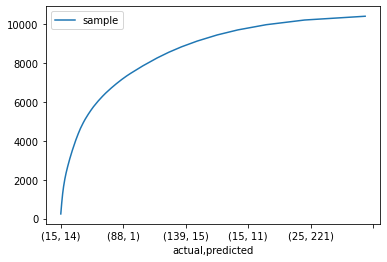

In [73]:
errors_df.groupby(['actual', 'predicted']).count().sort_values('sample', ascending=False).cumsum().plot()

In [66]:
errors_df.groupby(['actual', 'predicted']).count().sort_values('sample', ascending=False)

,,sample
actual,predicted,
15,14,243
221,225,215
227,225,179
216,225,176
2,14,174
...,...,...
38,194,1
186,14,1
38,191,1


In [69]:
print(errors_df[(errors_df['actual']=='15')&(errors_df['predicted']=='14')].count())
print(errors_df[(errors_df['actual']=='14')&(errors_df['predicted']=='15')].count())

sample       243
actual       243
predicted    243
dtype: int64
sample       40
actual       40
predicted    40
dtype: int64


In [79]:
grouped_filenames = collections.defaultdict(list)
group_to_spacegroup = {}

for filename in img_path.glob('valid/*'):
    sample, _, space_group, _ = filename.name.split('.')
    grouped_filenames[sample].append(filename.name)
    group_to_spacegroup[sample] = space_group

grouped_filenames = dict(grouped_filenames)
num_correct = 0



for group, filenames in tqdm.tqdm(grouped_filenames.items()):
    space_group = group_to_spacegroup[group]

    images = []
    for filename in filenames:
        fullpath = str(img_path/'valid'/filename)
        images.append(PIL.Image.open(fullpath).convert('L'))

    tensors = []
    for img in images:
        for angle in range(0, 360, 5):
            tensors.append(pipeline._make_tensor_for_test(img, angle))

    model.eval()
    with torch.no_grad():
        out = model(torch.stack(tensors).cuda())
        argmax = F.softmax(out, dim=1).mean(dim=0).argmax()
        assert False

  0%|          | 0/4110 [00:00<?, ?it/s]


AssertionError: 

In [81]:
out.shape

torch.Size([216, 200])

In [100]:
filenames, space_group

(['341_sample_2_6.0.88.png',
  '341_sample_2_6.1.88.png',
  '341_sample_2_6.2.88.png'],
 '88')

In [112]:
F.softmax(out, dim=1).mean(dim=0).topk(k=5)

torch.return_types.topk(
values=tensor([0.0656, 0.0526, 0.0443, 0.0424, 0.0411], device='cuda:0'),
indices=tensor([154,  72, 189,  10,  82], device='cuda:0'))

In [113]:
F.softmax(out, dim=1).mean(dim=0).argmax()

tensor(154, device='cuda:0')

In [105]:
F.softmax(out[0])

/home/jin/sandbox/smc_challenge2/smc_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([0.0083, 0.0095, 0.0027, 0.0135, 0.0041, 0.0063, 0.0003, 0.0051, 0.0031,
        0.0049, 0.0200, 0.0084, 0.0013, 0.0035, 0.0012, 0.0176, 0.0052, 0.0024,
        0.0085, 0.0008, 0.0020, 0.0091, 0.0065, 0.0047, 0.0052, 0.0049, 0.0020,
        0.0059, 0.0038, 0.0153, 0.0023, 0.0005, 0.0019, 0.0013, 0.0016, 0.0013,
        0.0057, 0.0148, 0.0026, 0.0038, 0.0013, 0.0016, 0.0035, 0.0045, 0.0076,
        0.0053, 0.0034, 0.0026, 0.0006, 0.0012, 0.0016, 0.0038, 0.0014, 0.0022,
        0.0018, 0.0015, 0.0117, 0.0025, 0.0056, 0.0007, 0.0020, 0.0007, 0.0010,
        0.0073, 0.0043, 0.0103, 0.0013, 0.0008, 0.0029, 0.0012, 0.0082, 0.0008,
        0.0235, 0.0009, 0.0019, 0.0100, 0.0022, 0.0119, 0.0007, 0.0006, 0.0039,
        0.0023, 0.0189, 0.0014, 0.0161, 0.0095, 0.0044, 0.0052, 0.0016, 0.0006,
        0.0015, 0.0054, 0.0113, 0.0009, 0.0025, 0.0029, 0.0031, 0.0055, 0.0019,
        0.0037, 0.0008, 0.0100, 0.0027, 0.0024, 0.0036, 0.0014, 0.0024, 0.0019,
        0.0087, 0.0013, 0.0021, 0.0033, 

In [111]:
topk = F.softmax(out, dim=1).mean(dim=0).topk(k=30)
print(topk)

for idx, val in zip(topk.indices, topk.values):
    label = cbed_data_loader.label_manager.raw_labels[idx]
    
    print(f"{label:3s}", round(100*val.item(), 4))

torch.return_types.topk(
values=tensor([0.0656, 0.0526, 0.0443, 0.0424, 0.0411, 0.0389, 0.0328, 0.0271, 0.0263,
        0.0212, 0.0200, 0.0176, 0.0141, 0.0117, 0.0106, 0.0099, 0.0099, 0.0092,
        0.0091, 0.0087, 0.0085, 0.0081, 0.0075, 0.0075, 0.0073, 0.0072, 0.0071,
        0.0071, 0.0069, 0.0068], device='cuda:0'),
indices=tensor([154,  72, 189,  10,  82, 186,  15, 147, 116,  84,  37, 145,  29,   3,
         56, 141, 199, 126, 121,  92,  77, 171,  75,  65, 183, 168,  85, 112,
        143, 101], device='cuda:0'))
100 6.5595
130 5.262
103 4.4315
221 4.2381
60  4.1113
116 3.8871
62  3.2785
159 2.7071
83  2.6283
187 2.1177
20  2.0008
66  1.7563
58  1.4148
167 1.1682
161 1.0562
110 0.9929
108 0.9901
3   0.9228
126 0.9137
69  0.8653
155 0.8459
102 0.8069
164 0.7531
113 0.7473
111 0.7273
181 0.7183
149 0.7121
220 0.7067
182 0.6897
109 0.6787


In [93]:
cbed_data_loader.label_manager.raw_labels[154]

'100'

In [123]:
pipeline.ModelOptBuf().load(model, opt, '/tmp/dropout_cutout4')

In [134]:
outcomes = pipeline.test_validation_set(img_path, model, cbed_data_loader.label_manager)

  0%|          | 10/20400 [00:01<1:07:00,  5.07it/s]


6 20400


In [135]:
for outcome in outcomes:
    if outcome.actual == outcome.predicted: continue
    
    print(outcome)

PredictionOutcome(sample='341_sample_2_6', actual='88', predicted='14', topk_values=[-4.3986029624938965, -4.927013874053955, -4.945870399475098, -5.079024791717529, -5.081502437591553], topk_cats=['14', '225', '2', '5', '15'])
PredictionOutcome(sample='223_sample_2_3', actual='1', predicted='166', topk_values=[-4.496982097625732, -4.70926570892334, -5.016360282897949, -5.083792209625244, -5.120553016662598], topk_cats=['166', '14', '63', '139', '225'])
PredictionOutcome(sample='237_sample_5_1', actual='136', predicted='14', topk_values=[-4.7234416007995605, -4.913516044616699, -5.086152076721191, -5.108957290649414, -5.123511791229248], topk_cats=['14', '136', '62', '1', '2'])
PredictionOutcome(sample='319_sample_0_8', actual='2', predicted='14', topk_values=[-4.539793968200684, -4.578898906707764, -4.846573352813721, -5.014871120452881, -5.137719631195068], topk_cats=['14', '2', '1', '139', '166'])
PredictionOutcome(sample='151_sample_2_7', actual='147', predicted='4', topk_values=[-

In [131]:
outcomes[:5]

[PredictionOutcome(sample='83_sample_2_5', actual='198', predicted='198', topk_values=[0.026920711621642113, 0.007386916782706976, 0.005507403519004583, 0.005405521485954523, 0.005327933933585882], topk_cats=['198', '19', '14', '176', '139']),
 PredictionOutcome(sample='346_sample_6_5', actual='2', predicted='2', topk_values=[0.01503811776638031, 0.00787915475666523, 0.006932166870683432, 0.006700919941067696, 0.006496070418506861], topk_cats=['2', '225', '12', '221', '139']),
 PredictionOutcome(sample='341_sample_2_6', actual='88', predicted='14', topk_values=[0.015285809524357319, 0.008213683031499386, 0.007559382356703281, 0.00642734207212925, 0.0062938774935901165], topk_cats=['14', '225', '2', '5', '15']),
 PredictionOutcome(sample='156_sample_3_8', actual='141', predicted='141', topk_values=[0.028526153415441513, 0.0064929574728012085, 0.0055015431717038155, 0.005474638193845749, 0.005358243361115456], topk_cats=['141', '148', '1', '70', '166']),
 PredictionOutcome(sample='321_sa

In [132]:
outcomes[2]

PredictionOutcome(sample='341_sample_2_6', actual='88', predicted='14', topk_values=[0.015285809524357319, 0.008213683031499386, 0.007559382356703281, 0.00642734207212925, 0.0062938774935901165], topk_cats=['14', '225', '2', '5', '15'])

In [10]:
out.mean(dim=0).shape

torch.Size([200])

In [12]:
out.mean(dim=0).argmax()

tensor(51, device='cuda:0')

In [ ]:
F.softmax(out.

In [30]:
q.qsize()

0

In [17]:
q = torch.multiprocessing.Queue()

In [21]:
q.put("bar")

In [9]:
len(tensors)

216

In [2]:
img_path = path2/'img11'
    
cbed_data_loader = pipeline.CbedDataLoader(img_path)
tbw = torch.utils.tensorboard.SummaryWriter(comment='__img11_6')

num_classes = len(cbed_data_loader.label_manager.raw_labels)

model = pipeline.make_cnn_model(
    base_arch=fastai.vision.models.resnet18,
    num_classes=num_classes,
    pretrained=False
).cuda()

lr = 3e-2
opt = pipeline.LambOptimizer(model.parameters(), lr=lr)

learner = pipeline.Learner(
    model,
    F.cross_entropy,
    opt,
    tbw,
    cbed_data_loader.train_loader,
    cbed_data_loader.valid_loader,
)
learner.train_model(5, lr)

100%|██████████| 5/5 [08:17<00:00, 99.40s/it]


In [3]:
buf0 = pipeline.save_to_buf(model, opt)

In [10]:
pipeline.load_from_buf(buf0, model, opt)

lr = 1e-2
opt = pipeline.LambOptimizer(model.parameters(), lr=lr)

learner.train_model(10, lr)

buf1 = pipeline.save_to_buf(model, opt)

100%|██████████| 10/10 [13:29<00:00, 80.91s/it]


In [24]:
pipeline.load_from_buf(buf1, model, opt)

lr = 1e-2
opt = pipeline.LambOptimizer(model.parameters(), lr=lr)

learner.train_model(5, lr)

buf2 = pipeline.save_to_buf(model, opt)

100%|██████████| 5/5 [08:17<00:00, 99.41s/it]


In [14]:
opt.lr

0.03

In [4]:
_model = make_resnet18_1chan()
sum(p.numel() for p in _model.parameters() if p.requires_grad)

1254580

In [5]:
_model = fastai.vision.models.resnet18()
sum(p.numel() for p in _model.parameters() if p.requires_grad)

11689512

In [2]:
img_path = path2/'img9'

cbed_data_loader = pipeline.CbedDataLoader(
    img_path, batch_size=700, chans='L')

444018it [01:39, 4452.02it/s]
61200it [00:13, 4471.62it/s]


Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()


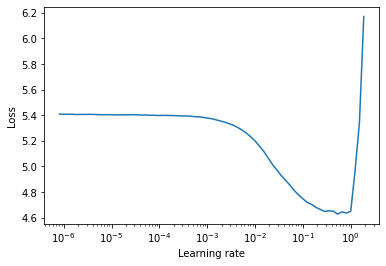

In [3]:
num_classes = len(cbed_data_loader.label_manager.raw_labels)

model = pipeline.make_cnn_model1d_flat(
    base_arch=pipeline.make_resnet50_1chan,
    num_classes=num_classes,
    pretrained=False
).cuda()
# pipeline.freeze_body(model)

criterion = torch.nn.CrossEntropyLoss()

# opt = pipeline.Lamb2(model.parameters(), lr=1e-7, wd=0.01)
# opt = apex.optimizers.FusedLAMB(model.parameters(), lr=1e-7)

opt = pipeline.Lamb2(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = torch_lr_finder.LRFinder(model, opt, criterion, device="cuda")
lr_finder.range_test(cbed_data_loader.train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [16]:
num_classes = 200

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()


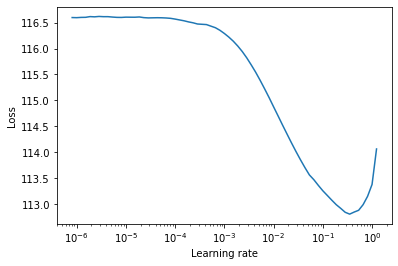

In [17]:
img_path = path2/'img9'

# cbed_data_loader = pipeline.CbedDataLoader(img_path, chans='L')

# criterion = torch.nn.CrossEntropyLoss()
model = pipeline.make_resnet34_1chan(
        pretrained=False,
        num_classes=num_classes,
        dropout=0.25,
    ).cuda()

opt2 = pipeline.Lamb2(model.parameters(), lr=1e-7, weight_decay=0.01)
criterion = pipeline.LabelSmoothingCrossEntropy(eps=0.1)

lr_finder = torch_lr_finder.LRFinder(model, opt2, criterion, device="cuda")
lr_finder.range_test(cbed_data_loader.train_loader, end_lr=100, num_iter=100, diverge_th=1.5)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()


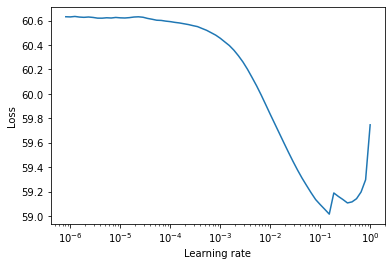

In [18]:
img_path = path2/'img9'

# cbed_data_loader = pipeline.CbedDataLoader(img_path, chans='L')

# criterion = torch.nn.CrossEntropyLoss()
model = pipeline.make_resnet34_1chan(
        pretrained=False,
        num_classes=num_classes,
        dropout=0.25,
    ).cuda()

opt2 = pipeline.Lamb2(model.parameters(), lr=1e-7, weight_decay=0.01)
criterion = pipeline.LabelSmoothingCrossEntropy(eps=0.05)

lr_finder = torch_lr_finder.LRFinder(model, opt2, criterion, device="cuda")
lr_finder.range_test(cbed_data_loader.train_loader, end_lr=100, num_iter=100, diverge_th=1.5)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()


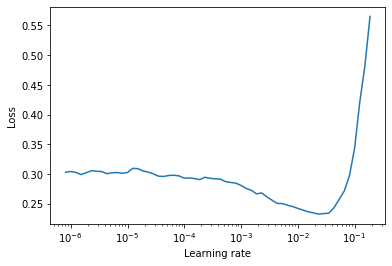

In [17]:
img_path = path2/'img11'

cbed_data_loader = pipeline.CbedDataLoader(img_path)

criterion = torch.nn.CrossEntropyLoss()

opt2 = pipeline.LambOptimizer(model.parameters(), lr=1e-7, wd=0.01)

# optimizer = pipeline.Lamb2(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = torch_lr_finder.LRFinder(model, opt2, criterion, device="cuda")
lr_finder.range_test(cbed_data_loader.train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [6]:
pipeline.make_resnet34_1chan(dropout=True)

ResNet1Chan(
  (conv1): Conv2d(1, 20, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tru

In [18]:
pipeline.load_from_buf(buf, model, opt)

In [22]:
cbed_data_loader_rgb = pipeline.CbedDataLoader(img_path, chans='RGB')
cbed_data_loader_l = pipeline.CbedDataLoader(img_path, chans='L')

87798it [00:18, 4709.41it/s]
12330it [00:02, 4627.98it/s]
87798it [00:18, 4838.32it/s]
12330it [00:02, 4728.99it/s]


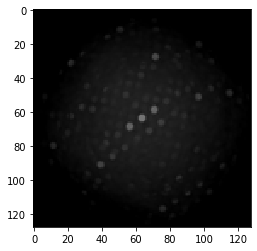

In [16]:
img = PIL.Image.open(filename).convert('RGB')

img = torchvision.transforms.functional.rotate(
    img, -30, resample=PIL.Image.BICUBIC)

img_t = torchvision.transforms.functional.to_tensor(img)

pipeline.imshow(img_t)

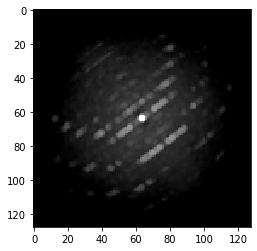

In [7]:
pipeline.imshow(cbed_data_loader._train_set[0][0])

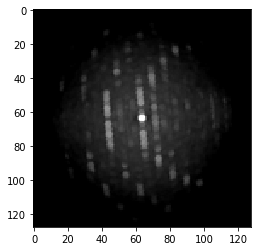

In [8]:
pipeline.imshow(cbed_data_loader._train_set[0][0])

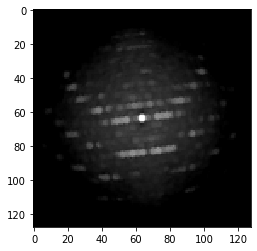

In [9]:
pipeline.imshow(cbed_data_loader._train_set[0][0])

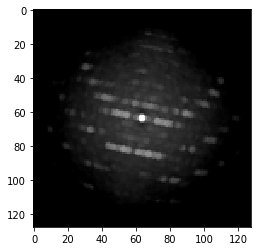

In [10]:
pipeline.imshow(cbed_data_loader._train_set[0][0])